In [10]:
import pandas as pd
import matplotlib.pyplot as plt

### (a)

   Index  Eruptions  Waiting
0      1      3.600       79
1      2      1.800       54
2      3      3.333       74
3      4      2.283       62
4      5      4.533       85


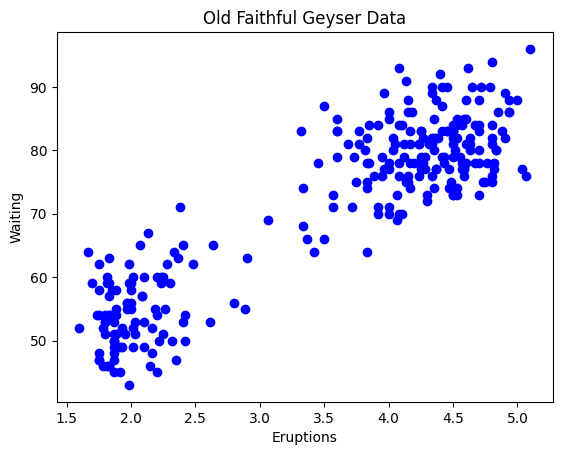

In [11]:
# Load the dataset
file_name = "eruptions_waiting.csv"
data = pd.read_csv(file_name)

# Print the first few rows of the DataFrame.
print(data.head())

# Extract the two features - eruptions and waiting time
eruptions = data['Eruptions']
waiting = data['Waiting']

# Create a scatter plot
plt.scatter(eruptions, waiting, c='blue', marker='o')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.title('Old Faithful Geyser Data')

# Show the plot
plt.show()

### (b)

In the GMM and EM algorithm, $P_{\theta_t}(z = k \mid x)$ represents the probability that a data point($x$) is inside the cluster $k$ according to the current parameter estimates $\theta_t$. Also, $\theta_t$ iucludes mean, covariance, and the mixing coefficients of the GMM at iteration $t$.

Using Bayes' theorem, the probability expression is:

$P_{\theta_t}(z = k \mid x) = \frac{P_{\theta_t}(z=k, x)}{P_{\theta_t}(x)} = \frac{P_{\theta_t}(z=k,x)}{ \sum_{l=1}^K P_{\theta_t}(x \mid z = l) P_{\theta_t}(z = l)} = \frac{P_{\theta_t}(x \mid z = k) P_{\theta_t}(z = k))}{ \sum_{l=1}^K P_{\theta_t}(x \mid z = l) P_{\theta_t}(z = l)}$

### (c)

In the M-step of the EM algorithm for Gaussian Mixture Models, we update the model parameters ($\mu_k, \Sigma_k, \varphi_k$) to maximize the expected log-likelihood. These updated parameters are calcutated based on the posterior probabilities $P_{\theta_t}(z = k \mid x)$ computed in E-step.

The updated parameters are:

$\mu^{t+1}_k = \frac{\sum_{i=1}^{n} P_{\theta_t}(z = k \mid x^{(i)})x^{(i)}}{\sum_{i=1}^{n}P_{\theta_t}(z = k \mid x^{(i)})} $


$\Sigma^{t+1}_k = \frac{\sum_{i=1}^{n} P_{\theta_t}(z = k \mid x^{(i)})(x^{(i)} - \mu^{t+1}_k)(x^{(i)} - \mu^{t+1}_k)^T}{\sum_{i=1}^{n} P_{\theta_t}(z = k \mid x^{(i)})} $



$\varphi^{t+1}_k = \frac{1}{n} \sum_{i=1}^{n} P_{\theta_t} (z = k \mid x^{(i)}) $





### (d)

In [12]:
import numpy as np
from scipy.stats import multivariate_normal

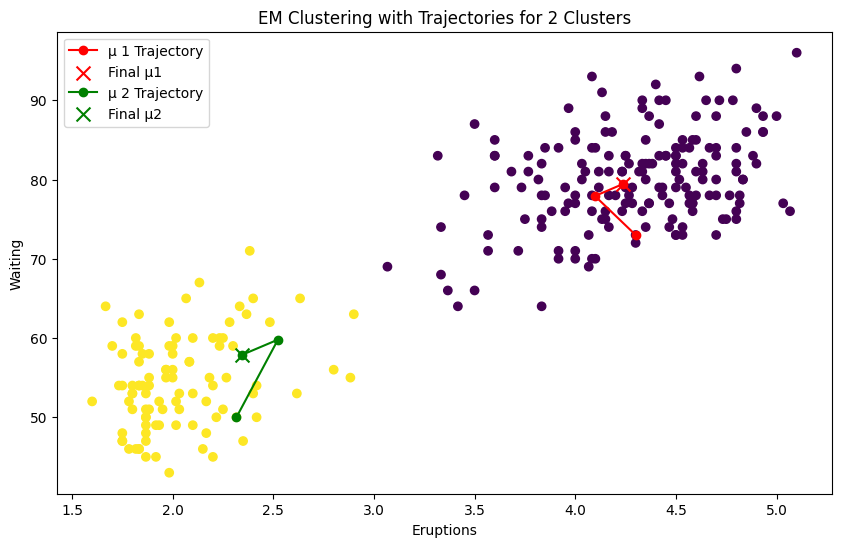

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Load the dataset
file_name = "eruptions_waiting.csv"
data = pd.read_csv(file_name)
X = data[['Eruptions', 'Waiting']].to_numpy()

# Initialize parameters for 2 clusters
np.random.seed(42)
mus = X[np.random.choice(X.shape[0], 2, replace=False)]  # Randomly select two data points as initial means
sigmas = np.array([np.cov(X, rowvar=False)] * 2)  # Use the overall covariance as initial covariance matrices
pis = np.array([0.5, 0.5])  # Assume both clusters have equal initial probabilities

# E-step
def e_step(X, mus, sigmas, pis):
    n, _ = X.shape
    responsibilities = np.zeros((n, 2))

    for i in range(2):
        responsibilities[:, i] = pis[i] * multivariate_normal.pdf(X, mean=mus[i], cov=sigmas[i])

    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]
    return responsibilities

# M-step
def m_step(X, responsibilities):
    n, d = X.shape
    mus = np.zeros((2, d))
    sigmas = np.zeros((2, d, d))
    pis = np.zeros(2)

    for i in range(2):
        Nk = responsibilities[:, i].sum()
        mus[i] = (responsibilities[:, i, np.newaxis] * X).sum(axis=0) / Nk
        sigmas[i] = np.cov(X.T, aweights=responsibilities[:, i], bias=True)
        pis[i] = Nk / n

    return mus, sigmas, pis

# EM algorithm: alternate between E-step and M-step
def em_algorithm(X, mus, sigmas, pis, max_iters=100, tol=1e-4):
    mus_list = [mus.copy()] # Added to store mus at each iteration
    prev_ll = -np.inf # Initialize log-likelihood

    for _ in range(max_iters):
        responsibilities = e_step(X, mus, sigmas, pis)
        mus, sigmas, pis = m_step(X, responsibilities)
        mus_list.append(mus.copy())
        
        ll = np.sum(np.log(np.sum(responsibilities, axis=1)))
        if np.abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    return mus, sigmas, pis, responsibilities, np.array(mus_list)

# Run EM algorithm
mus, sigmas, pis, responsibilities, mus_list = em_algorithm(X, mus, sigmas, pis)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=responsibilities.argmax(axis=1), cmap='viridis')

colors = ['r', 'g']
for i in range(2):
    plt.plot(mus_list[:, i, 0], mus_list[:, i, 1], color=colors[i], marker='o', label=f'μ {i+1} Trajectory')
    plt.scatter(mus[i, 0], mus[i, 1], color=colors[i], marker='x', s=100, label=f'Final μ{i+1}')

plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.title('EM Clustering with Trajectories for 2 Clusters')
plt.legend()
plt.show()



The termination criteria for EM algorithm is based on the stability and change of log-likelihood between the iterations. Since log-likelihood value helps ensure EM algorithm to converge to the solution effectively without overfitting, I used it as 'll = np.sum(np.log(np.sum(responsibilities, axis=1)))'. As a result, the EM algorithm stops iterating when the absolute difference of two consecutive iterations is less than a tolerance level of (tol=1e-4).

### (e)

In [15]:
from sklearn.cluster import KMeans

### Using Elbow Method to find the best K for K-Means

/Users/andrewpark/Library/Python/3.11/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andrewpark/Library/Python/3.11/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andrewpark/Library/Python/3.11/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/andrewpark/Library/Python/3.11/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The 

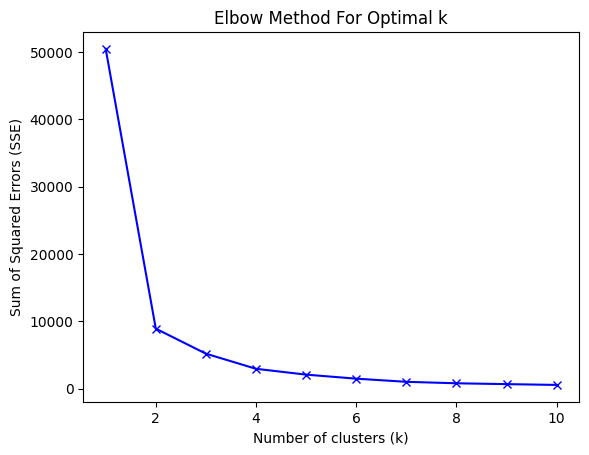

In [28]:
# Compute SSE(sum of square errors) for different values of k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) # inertia_ is the sum of squared distances of samples to their closest cluster center

# Plot SSE against k
plt.figure()
plt.plot(range(1, 11), sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

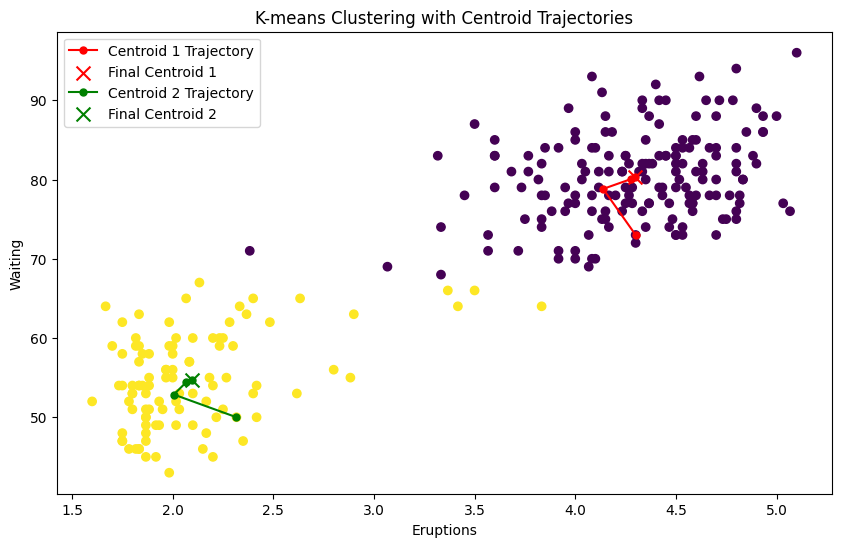

In [ ]:
def kmeans_clustering(X, k, max_iters=100):
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]  # Initialize centroids
    centroids_trajectory = [centroids]  # To store the trajectory of centroids
    prev_labels = np.zeros(X.shape[0])

    for _ in range(max_iters):
        # Compute distances to centroids
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))

        # Assign labels
        labels = np.argmin(distances, axis=0)

        if np.all(labels == prev_labels):
            # If labels didn't change, the algorithm converged
            break
        
        prev_labels = labels

        # Update centroids
        centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        centroids_trajectory.append(centroids)
    
    return labels, np.array(centroids_trajectory)

# From the plot, applying k=2 instead of optimal k=3 and apply K-means clustering
# Apply K-means clustering
optimal_k = 2
labels, centroids_trajectory = kmeans_clustering(X, optimal_k)

# Plot K-means clustering results with centroid's trajectory
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')

# Plot centroids trajectory
colors = ['r', 'g']
for i in range(optimal_k):
    plt.plot(centroids_trajectory[:, i, 0], centroids_trajectory[:, i, 1], color=colors[i], marker='o', markersize=5, label=f'Centroid {i+1} Trajectory')
    plt.scatter(centroids_trajectory[-1, i, 0], centroids_trajectory[-1, i, 1], color=colors[i], marker='x', s=100, label=f'Final Centroid {i+1}')

plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.title('K-means Clustering with Centroid Trajectories')
plt.legend()
plt.show()

K-means and the EM algorithm are both prominent clustering models used in unsupervised learning, yet they yield subtly different results. Upon observation, the clusters formed by the EM algorithm appeared more reasonable, particularly when considering central areas and outliers like the point at (2.5, 70), which was distant from centroid 1 of K-Means. The K-Means algorithm's suitability largely lies with data that exhibits convex and isotropic shapes, leading to potential limitations in clustering efficacy for data points that are part of elongated clusters. In contrast, the EM algorithm, taking into account the covariance structure of the data and latent Gaussians, offers a soft-clustering solution. This approach often results in more refined and flexible cluster formations, adeptly handling a variety of data shapes and densities. However, given the largely similar clustering results, it can be inferred that the dataset is suitable for both K-means and EM algorithm applications.